## Problem Statement :-

A hedge fund uses <b>6 financial factors to predict the alpha signal</b> in a stock. This alpha signal is used to make purchase decisions about the stock. The hedge fund now collected and tagged microblogging data for sentiment from the Social Media platform called ‘StockTwits’.<br><br>
<b>StockTwits is used by people who regularly trade stocks.</b> People on this platform tweet about stocks using the special character ‘$’ to indicate the name of the stock. These microblogs similar to tweets might contain important information about the alpha signal in a stock.<br>

The hedge fund has anonymyzed the data, which contains 7 stock factors and an alpha signal. This alpha signal is generated using a near perfect algorithmic trading strategy. Unfortunately, the number of stock factors, collected to run that strategy, are extremely high and have to be collected from a large number of data vendors at a high price.

<br>
 
### Goal of the Activity :- 
<li>Build a sentiment analysis model using the tagged data. 
<li>This sentiment analysis model should then be used to generate a new stock factor which together with the other stock factors should be used to predict the Alpha Signal.<br>

#### Problem Type:
1. Multi class classification for doing sentiment analysis.
2. Multi class classification for identifying Alpha value

#### Metrics for Evaluation:
F1 score as a final output for identifying Alpha Vaue

#### Variable to Predict:
Alpha score for any hedge fund

#### Benefit of this solution :-

Replicating the alpha signal generated from that strategy using just the 7 Stock Factors and the factor generated from sentiment analysis of the stocktwits would make the company incur significantly less costs to perform their trades.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
import re
import datetime as dt
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM

from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

%matplotlib inline

Using TensorFlow backend.


## User defined functions

#### 1. Inspecting data details for a dataframe

In [2]:
# Information of variables for data set:
def inspect_data(data):
    data_details =  pd.DataFrame({"Data Type":data.dtypes,
                         "Count of Blank Values":data.apply(lambda x: x.isin([' ']).sum(),axis=0),          
                        "Count of Missing Values":data.apply(lambda x: x.isnull().sum(),axis=0),
                         "% of Missing Values":data.apply(lambda x: round(x.isnull().sum()/len(x.index)*100,2),axis=0),
                        "No of Unique Data":data.apply(lambda x: x.nunique(),axis=0),
                         "Levels":data.apply(lambda x: str(x.unique()),axis=0)
                        })
    return data_details#### 2. Finding numeric and categorical column details

#### 2. identifying the pattern in a sentence

In [4]:
import re
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt


#### 3. Categorical and numerical columns

In [4]:
def col_type(df):
    category='object'
    catcols=df.select_dtypes(include=category).columns
    numcols=df.select_dtypes(exclude=category).columns
    return catcols,numcols

#### 4. Categorical columns plot function

In [5]:
def catcol_plot(df,target):
    cols=col_type(df)
    cat_cols=cols[0]
    colrefs=list(df[cat_cols].columns)
    colrefs.remove(target)
    #remove customerid/index details
    colrefs=colrefs[1:]
    for col in colrefs:
        #print(col)
        plt.figure(figsize = (8,6))
        plt.subplot(1,1,1)
        sns.countplot(x=col,data=df,hue=target).set_title(col + " vs " + target)
        plt.legend(loc='upper center', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=65, horizontalalignment='right',fontweight='light')

#### 5. Numerical column plot function

In [6]:
def numcol_plot(df,target):
    cols=col_type(df)
    num_cols=cols[1]
    colrefs=list(df[num_cols].columns)
    colrefs.remove(target)
    #remove customerid/index details
    colrefs=colrefs[1:]
    for col in colrefs:
        #print(col)
        plt.figure(figsize = (8,6))
        plt.subplot(1,1,1)
        sns.scatterplot(x=col,data=df,y=target).set_title(col + " vs " + target)
        #plt.legend(loc='upper center', bbox_to_anchor=(1, 0.8))
        #plt.xticks(rotation=65, horizontalalignment='right',fontweight='light')

## Part-A : Sentiment Analysis

### Data Pre-processing

#### A. Reading the json file

In [7]:
data = pd.read_json('train_data-1573118738755.json')

In [8]:
data.head()

,records
0,{'stocktwit_tweet': '$AMD going up but hesitat...
1,{'stocktwit_tweet': '@inforlong @MariaGascon D...
2,"{'stocktwit_tweet': '$AVGO WTF?', 'sentiment_s..."
3,{'stocktwit_tweet': '$PH New Insider Filing O...
4,{'stocktwit_tweet': '$FB if it bounces tommorr...


In [9]:
data.records[1]

{'stocktwit_tweet': '@inforlong @MariaGascon Despite\nChina trade war $CAT held very well 👍',
 'sentiment_score': 3,
 'timestamp': '2018-10-09 03:51:06+00:00',
 'ticker': '$CAT'}

In [10]:
# Splitting the records column
tweet_df=json_normalize(data.records)
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


In [11]:
tweet_df.stocktwit_tweet[3]

'$PH\n New Insider Filing On: \n MULLER KLAUS PETER\nTransaction Code: \n http://www.filingscanner.com/Alerts/PH.php'

In [12]:
tweet_df.shape

(1039131, 4)

In [13]:
tweet_df.ticker.nunique()

2181

In [14]:
#df.to_csv("tweets.csv",index=False)

In [15]:
tweet_df.describe()

,sentiment_score
count,1.039131e+06
mean,2.203079e+00
std,1.105371e+00
min,0.000000e+00
25%,2.000000e+00
50%,2.000000e+00
75%,3.000000e+00
max,4.000000e+00


In [16]:
tweet_df.sentiment_score.value_counts()

2    464402
3    208031
4    153905
1    120771
0     92022
Name: sentiment_score, dtype: int64

## Text Pre Processing for the tweets- Feature Engineering

### A. Finding count of words in each tweet

In [17]:
tweet_df['word_count'] = tweet_df['stocktwit_tweet'].apply(lambda x: len(str(x).split(" ")))

In [18]:
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11


### B. Finding count of characters in each tweet

In [19]:
tweet_df['char_count'] = tweet_df['stocktwit_tweet'].str.len() ## this also includes spaces
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55


### C. Finding numerics in each tweet

In [20]:
tweet_df['numerics'] = tweet_df['stocktwit_tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0


### D. Finding upper letters in each tweet

In [21]:
tweet_df['upper'] = tweet_df['stocktwit_tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2


### E. Number of stopwords in the tweet

In [22]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [23]:
tweet_df['stopwords'] = tweet_df['stocktwit_tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5


### F. Finding average word length in the tweets

In [24]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [25]:
tweet_df['avg_word'] = tweet_df['stocktwit_tweet'].apply(lambda x: avg_word(x))
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909


### G. Finding count of emojis used

In [26]:
import emojis
tweet_df['emoji_count'] = tweet_df['stocktwit_tweet'].apply(lambda x: emojis.count(x))
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0


In [27]:
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0


### H. Getting datetime from the timestamp

In [28]:
#Creating datetime object 
tweet_df['datetime']=pd.to_datetime(tweet_df['timestamp'],format='%Y-%m-%d %H:%M:%S')
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count,datetime
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0,2018-08-23 19:07:54+00:00


In [29]:
#Storing extracted information in new columns:
tweet_df['date']= tweet_df['datetime'].dt.date
tweet_df['day']=tweet_df['datetime'].apply(lambda x:x.day)
tweet_df['hour']=tweet_df['datetime'].apply(lambda x:x.hour)
#tweet_df['day_of_week']=tweet_df['datetime'].apply(lambda x:calendar.day_name[x.weekday()])
tweet_df['month']=tweet_df['datetime'].apply(lambda x:x.month)
tweet_df['year']=tweet_df['datetime'].apply(lambda x:x.year)

tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count,datetime,date,day,hour,month,year
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0,2018-09-19 18:38:28+00:00,2018-09-19,19,18,9,2018
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1,2018-10-09 03:51:06+00:00,2018-10-09,9,3,10,2018
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0,2018-07-12 13:35:32+00:00,2018-07-12,12,13,7,2018
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0,2018-07-19 03:32:50+00:00,2018-07-19,19,3,7,2018
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0,2018-08-23 19:07:54+00:00,2018-08-23,23,19,8,2018


In [30]:
# `Combining the details of year, month and day to get the new column for datetime
tweet_df['tweet_date']=pd.to_datetime((tweet_df.year*10000+tweet_df.month*100+tweet_df.day).apply(str),format='%Y%m%d')

In [31]:
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count,datetime,date,day,hour,month,year,tweet_date
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0,2018-09-19 18:38:28+00:00,2018-09-19,19,18,9,2018,2018-09-19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1,2018-10-09 03:51:06+00:00,2018-10-09,9,3,10,2018,2018-10-09
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0,2018-07-12 13:35:32+00:00,2018-07-12,12,13,7,2018,2018-07-12
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0,2018-07-19 03:32:50+00:00,2018-07-19,19,3,7,2018,2018-07-19
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0,2018-08-23 19:07:54+00:00,2018-08-23,23,19,8,2018,2018-08-23


### I. Finding Url's present in the tweets

In [32]:
from urlextract import URLExtract
extractor = URLExtract()
#urls = extractor.find_urls("Let's have URL example.com example.")
#print(urls) # prints: ['example.com']

In [33]:
tweet_df['url']=tweet_df.stocktwit_tweet.apply(lambda x:extractor.find_urls(x))

In [34]:
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count,datetime,date,day,hour,month,year,tweet_date,url
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0,2018-09-19 18:38:28+00:00,2018-09-19,19,18,9,2018,2018-09-19,[]
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1,2018-10-09 03:51:06+00:00,2018-10-09,9,3,10,2018,2018-10-09,[]
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0,2018-07-12 13:35:32+00:00,2018-07-12,12,13,7,2018,2018-07-12,[]
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0,2018-07-19 03:32:50+00:00,2018-07-19,19,3,7,2018,2018-07-19,[http://www.filingscanner.com/Alerts/PH.php]
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0,2018-08-23 19:07:54+00:00,2018-08-23,23,19,8,2018,2018-08-23,[]


In [35]:
#verifing if url got extracted
tweet_df.url[3]

['http://www.filingscanner.com/Alerts/PH.php']

In [ ]:
#tweet_sorted=tweet_df.sort_values(‘url’, ascending=False)

In [29]:
#import emoji

In [32]:
#def filter_emojis(sentence):
#        return [word for word in sentence.split() if str(word.encode('unicode-escape'))[2] != '\\' ]

In [33]:
#filter_emojis(tweet_df.stocktwit_tweet[1])

['@inforlong',
 '@MariaGascon',
 'Despite',
 'China',
 'trade',
 'war',
 '$CAT',
 'held',
 'very',
 'well']

## Data cleaning

#### 1. Removing Twitter Handles (@user)

In [36]:
tweet_df['tweet'] = np.vectorize(remove_pattern)(tweet_df['stocktwit_tweet'], "@[\w]*")
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count,datetime,date,day,hour,month,year,tweet_date,url,tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0,2018-09-19 18:38:28+00:00,2018-09-19,19,18,9,2018,2018-09-19,[],$AMD going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1,2018-10-09 03:51:06+00:00,2018-10-09,9,3,10,2018,2018-10-09,[],Despite\nChina trade war $CAT held very well 👍
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0,2018-07-12 13:35:32+00:00,2018-07-12,12,13,7,2018,2018-07-12,[],$AVGO WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0,2018-07-19 03:32:50+00:00,2018-07-19,19,3,7,2018,2018-07-19,[http://www.filingscanner.com/Alerts/PH.php],$PH\n New Insider Filing On: \n MULLER KLAUS P...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0,2018-08-23 19:07:54+00:00,2018-08-23,23,19,8,2018,2018-08-23,[],$FB if it bounces tommorrow do the right thing...


#### 2. Removing list of urls from tweets

In [46]:
#Initial tweet with https
tweet_df.tweet[3]

'$PH\n New Insider Filing On: \n MULLER KLAUS PETER\nTransaction Code: \n http://www.filingscanner.com/Alerts/PH.php'

In [48]:
#Removing https
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: re.sub(r"http\S+", "",x))

In [49]:
#Validating that url is removed
tweet_df.tweet[3]

'$PH\n New Insider Filing On: \n MULLER KLAUS PETER\nTransaction Code: \n '

## Copying dataframe to build hastag analysis later

In [50]:
tweet_hash=tweet_df.copy()

#### 3. Updating apostrophe to blank values

In [52]:
tweet_df['tweet'] =tweet_df['tweet'].str.replace('&#39;',"'")

#### 4. Removing stopwords from tweets

In [53]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [54]:
tweet_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count,datetime,date,day,hour,month,year,tweet_date,url,tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0,2018-09-19 18:38:28+00:00,2018-09-19,19,18,9,2018,2018-09-19,[],$AMD going hesitating however chart stable goi...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1,2018-10-09 03:51:06+00:00,2018-10-09,9,3,10,2018,2018-10-09,[],Despite China trade war $CAT held well 👍
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0,2018-07-12 13:35:32+00:00,2018-07-12,12,13,7,2018,2018-07-12,[],$AVGO WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0,2018-07-19 03:32:50+00:00,2018-07-19,19,3,7,2018,2018-07-19,[http://www.filingscanner.com/Alerts/PH.php],$PH New Insider Filing On: MULLER KLAUS PETER ...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0,2018-08-23 19:07:54+00:00,2018-08-23,23,19,8,2018,2018-08-23,[],$FB bounces tommorrow right thing GTFO


In [55]:
tweet_df.tweet[1]

'Despite China trade war $CAT held well 👍'

#### 4. Removing Punctuations, Numbers, and Special Characters

In [56]:
tweet_df['tweet'] = tweet_df['tweet'].str.replace("[^a-zA-Z#]", " ")
tweet_df.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,word_count,char_count,numerics,upper,stopwords,avg_word,emoji_count,datetime,date,day,hour,month,year,tweet_date,url,tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,13,74,0,1,5,4.769231,0,2018-09-19 18:38:28+00:00,2018-09-19,19,18,9,2018,2018-09-19,[],AMD going hesitating however chart stable goi...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,10,69,0,1,1,5.363636,1,2018-10-09 03:51:06+00:00,2018-10-09,9,3,10,2018,2018-10-09,[],Despite China trade war CAT held well
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2,10,0,2,0,4.500000,0,2018-07-12 13:35:32+00:00,2018-07-12,12,13,7,2018,2018-07-12,[],AVGO WTF
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,12,111,0,4,0,8.727273,0,2018-07-19 03:32:50+00:00,2018-07-19,19,3,7,2018,2018-07-19,[http://www.filingscanner.com/Alerts/PH.php],PH New Insider Filing On MULLER KLAUS PETER ...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,11,55,0,2,5,4.090909,0,2018-08-23 19:07:54+00:00,2018-08-23,23,19,8,2018,2018-08-23,[],FB bounces tommorrow right thing GTFO
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02 11:40:49+00:00,6,34,0,1,1,5.600000,0,2018-08-02 11:40:49+00:00,2018-08-02,2,11,8,2018,2018-08-02,[],FB usual RED every day
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07 15:01:06+00:00,7,143,0,1,0,19.571429,0,2018-09-07 15:01:06+00:00,2018-09-07,7,15,9,2018,2018-09-07,[https://wallmine.com/news/17ckh3/unitedhealth...,AET UnitedHealth Group Goes Ex Dividend Today
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12 20:48:40+00:00,8,38,1,1,3,3.875000,0,2018-09-12 20:48:40+00:00,2018-09-12,12,20,9,2018,2018-09-12,[],NOC let s see hit
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28 01:19:27+00:00,14,77,0,2,3,4.571429,0,2018-10-28 01:19:27+00:00,2018-10-28,28,1,10,2018,2018-10-28,[],I bet you re also one saying AMZN Smh
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17 13:35:00+00:00,4,22,0,1,1,4.750000,0,2018-08-17 13:35:00+00:00,2018-08-17,17,13,8,2018,2018-08-17,[],AMD Pastor Stooge


In [57]:
tweet_df.tweet[1]

'Despite China trade war  CAT held well  '

The emoji has been removed as well with above code

#### 5. Converting all characters to lower cases

In [69]:
tweet_df['tweet']=tweet_df['tweet'].str.lower()

In [70]:
#Validating if the words are converted to lower case
tweet_df['tweet'][1]

'despite china trade war  cat held well  '

In [151]:
#!pip install urlextract

## Story Generation and visualization from text

### A) Understanding the common words used in the tweets: WordCloud </b>

Now I want to see how well the given sentiments are distributed across the dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.


In [137]:
#!pip install wordcloud

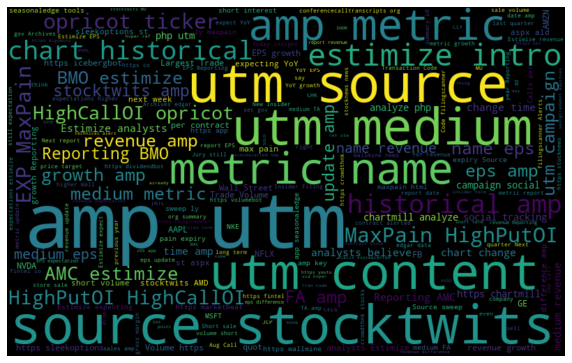

In [138]:
all_words = ' '.join([text for text in tweet_df['tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are related to financial terms being used. Words like <u><b>metric_name,chart, historical, estimize, analysts</u></b> are the most frequent ones.<br>
It is giving us a hint that a lot of tweets have historical information being mentioned.<br>
utm_source and utm_medium : depicts that links of a lot of websites have been given in the tweets. <br>

Refer the following link for details on utm: - https://en.wikipedia.org/wiki/UTM_parameters

### Word cloud : sentiment score=1

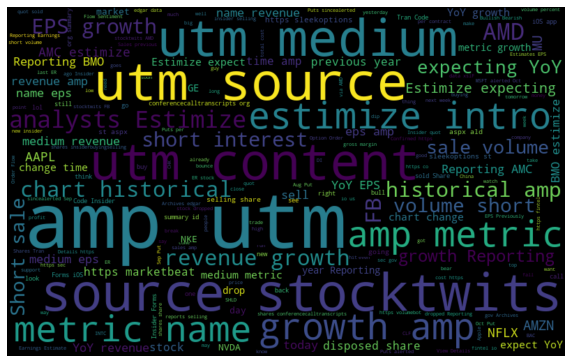

In [139]:
words_1 = ' '.join([text for text in tweet_df['tweet'][tweet_df['sentiment_score'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(words_1)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Most of the frequent words are compatible with the sentiment as observed in overall data.
A lot of emphasis has been given here on words like <b></u>'medium','metric_name','sale'</b></u> is observed<br>
This means that a lot of sentiment for score of 1 means <b>selling off </b> this hedge fund.

### Word cloud : sentiment score=0

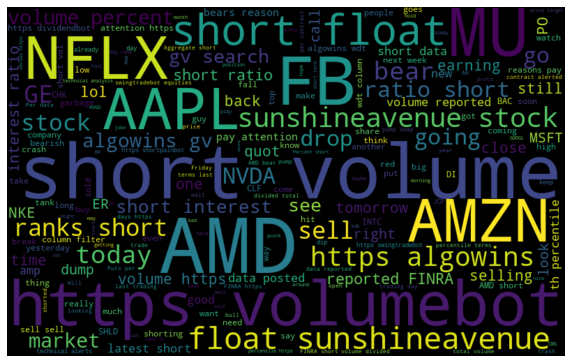

In [140]:
words_0 = ' '.join([text for text in tweet_df['tweet'][tweet_df['sentiment_score'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(words_0)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

A lot of emphasis has been given here on words like <b><u> hedge funds like : 'NFLX', 'AMZN','AAPL','AMD' & words like:'sell','short','volume'</b></u> is observed <br>

This means that the listed hedge fundscan be <b>sold out or rather can be used for short term holdings.</b>


### Word cloud : sentiment score=2

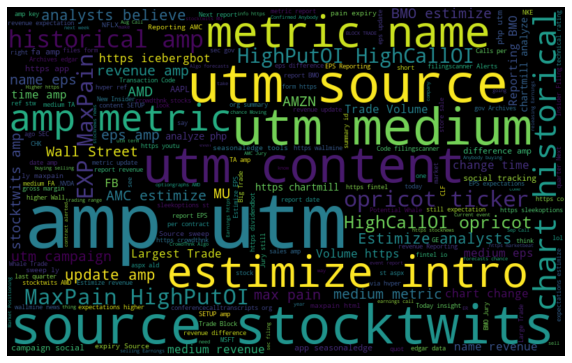

In [141]:
words_2 = ' '.join([text for text in tweet_df['tweet'][tweet_df['sentiment_score'] == 2]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(words_2)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Frequent words observed here are : <b><u> 'chart','historical','estimize','medium'</b></u><br>
No where words like <b> buy or sell </b> are coming out, which means these funds must be having <b>neutral sentiment</b>

### Word cloud : sentiment score=3

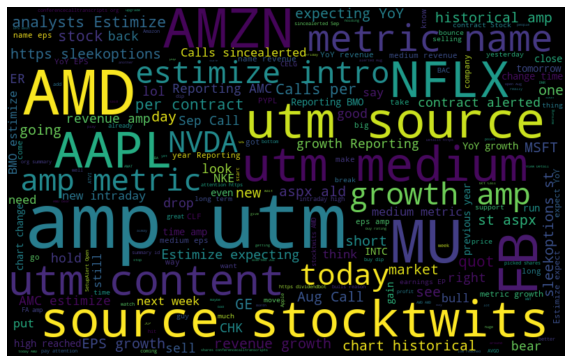

In [142]:
words_3 = ' '.join([text for text in tweet_df['tweet'][tweet_df['sentiment_score'] == 3]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(words_3)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Some clear hedge funds that can be observed here are : <b> NFLX, FB, AMZN, AMD,NVDA</b>.</br> No clear call out of buying or selling or holding these hedge funds is coming out , that means this also falls into <b>neutral sentiment </b>

### Word cloud : sentiment score=4

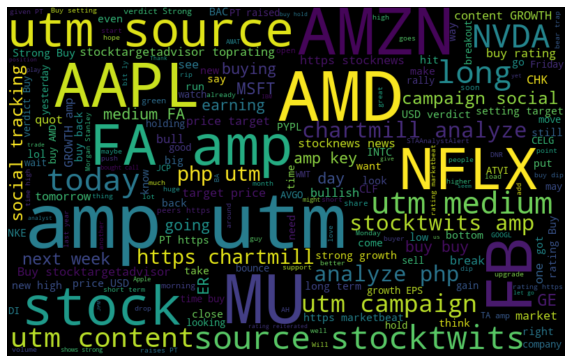

In [143]:
words_4 = ' '.join([text for text in tweet_df['tweet'][tweet_df['sentiment_score'] == 4]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(words_4)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Some common terms observed here are : <b> 'NFLX','AMD','NVDA','AMZN','buy','analyze','long'</b> are coming out clearly
<br>
This means stocks of these hedge funds have a <b>sentiment to buy them and keep them for longer duration</b>

### B. Building a countplot to understand relation between sentiment score and number of tweets

Text(0.5, 1.0, 'Tweet counts for different Sentiment scores')

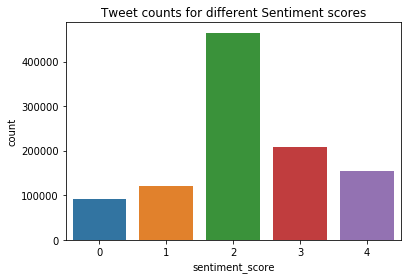

In [144]:
sns.countplot(x='sentiment_score',data=tweet_df)
plt.title('Tweet counts for different Sentiment scores')

The above graph clearly shows that there is a large amount of tweets for sentiment score=2
The sentiment information dataset is clearly <b>Imbalance dataset</b>

### C. Building a catplot to understand relation between sentiment score and length of words used in tweets

Text(0.5, 1, 'Words used across different sentiment_score')

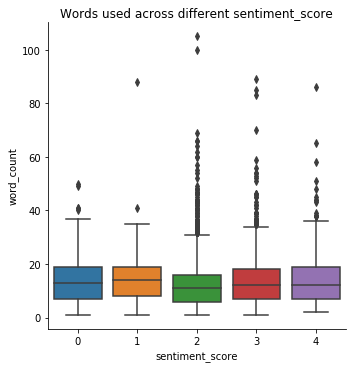

In [145]:
sns.catplot(x="sentiment_score", y="word_count",
            kind="box", dodge=False, data=tweet_df)
plt.title('Words used across different sentiment_score')

The above plot shows that there are a lot of words used for sentiment score of 2,3 and 4, that is beyond the general range of words or are falling as outliers.

Which means a lot of analysis and information is being passed in the sentiments for score of <b> 2,3,4 </b>

### D. Understanding number of emojis used across different sentiment scores

Text(0.5, 1.0, 'Emoji counts across different sentiment scores')

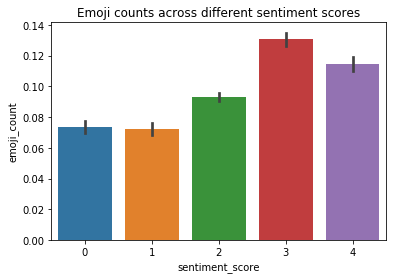

In [146]:
sns.barplot(x="sentiment_score", y="emoji_count",
             data=tweet_df)
plt.title('Emoji counts across different sentiment scores')

The above data shows that for a sentiment score of <b> 3 and 4 </b> a lot of emojis have been used.

### E. Understanding number of average words being used across different sentiment scores

Text(0.5, 1.0, 'Average words across different sentiment scores')

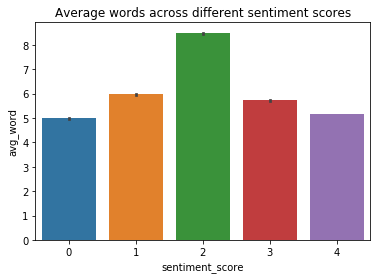

In [147]:
sns.barplot(x="sentiment_score", y="avg_word",
             data=tweet_df)
plt.title('Average words across different sentiment scores')

The average words used across different sentiment score is highest across sentiment score = 2.

### F. Understanding number of numerics being used across different sentiment scores

Text(0.5, 1.0, 'Numbers used across different sentiment scores')

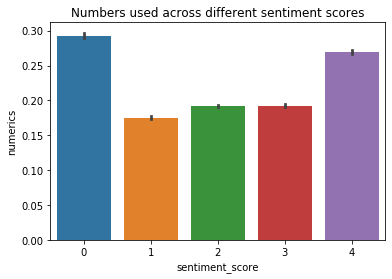

In [148]:
sns.barplot(x="sentiment_score", y="numerics",
             data=tweet_df)
plt.title('Numbers used across different sentiment scores')

<b>A lot of numeric information is being passed in sentiment score= 0 and sentiment score=4. <br>
Based on the understand from wordcloud, sentiment =0 is the case where these funds have been asked to sell <br>
whereas sentiment =4 are those which have been considered for buying or holding for long. <br></b>

For sure in order to decide to buy or sell a hedge fund a lot of data in terms of numbers is needed.

### G. Understanding number of tweets for different tickers

In [149]:
sns.countplot(x='ticker',data=tweet_df)
plt.title('Tweet counts for different Tickers')

Text(0.5, 1.0, 'Tweet counts for different Tickers')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1170add90> (for post_execute):


ValueError: 
$$amd
^
Expected end of text (at char 0), (line:1, col:1)

ValueError: 
$$amd
^
Expected end of text (at char 0), (line:1, col:1)

<Figure size 432x288 with 1 Axes>

## Model building

In order for any of the model to work on sentiments or text,text data needs to be converted to a vector form.<br>
There are multiple methods to do that. One of such method is using the TF-IDF value, which provides the importance of any term or word based on the occurrence frequency.

In [71]:
#Before doing any text to vector conversion, its important to understand class balance
tweet_df['sentiment_score'].value_counts()

2    464402
3    208031
4    153905
1    120771
0     92022
Name: sentiment_score, dtype: int64

This clearly shows that there is a class imbalance which needs to be handled before we do any model building.<br>
There are various methods to handle class Imbalance and one such method will be used here :- Upsampling post we do a train test split

### Train - Test Split

In [75]:
# Split data into training and test sets using stratify on sentiment score column to maintain class imbalance on test
X_train, X_test, y_train, y_test = train_test_split(tweet_df['tweet'], 
                                                    tweet_df['sentiment_score'], train_size=0.8,
                                                    random_state=1234, stratify=tweet_df['sentiment_score'])

In [80]:
y_train.value_counts()

2    371521
3    166425
4    123124
1     96617
0     73617
Name: sentiment_score, dtype: int64

In [81]:
y_test.value_counts()

2    92881
3    41606
4    30781
1    24154
0    18405
Name: sentiment_score, dtype: int64

#### Upsamping the train data to handle class imbalance

In [82]:
#Combining the train data file together
X = pd.concat([X_train, y_train], axis=1)

In [84]:
#Keeping dataframe for different score values- this will help in updating the samples count accordingly
sscore_0 = X[X.sentiment_score==0]
sscore_1 = X[X.sentiment_score==1]
sscore_2 = X[X.sentiment_score==2]
sscore_3 = X[X.sentiment_score==3]
sscore_4 = X[X.sentiment_score==4]

In [93]:
print("sentiment score:0, shape",sscore_0.shape)
print("sentiment score:1, shape",sscore_1.shape)
print("sentiment score:2, shape",sscore_2.shape)
print("sentiment score:3, shape",sscore_3.shape)
print("sentiment score:4, shape",sscore_4.shape)

sentiment score:0, shape (73617, 2)
sentiment score:1, shape (96617, 2)
sentiment score:2, shape (371521, 2)
sentiment score:3, shape (166425, 2)
sentiment score:4, shape (123124, 2)


##### Upsampling all the minority classes based on the majority class which is sentiment -score :2 class

In [94]:
# upsample minority class - score0
upsampled_0 = resample(sscore_0,
                          replace=True, # sample with replacement
                          n_samples=len(sscore_2), # match number in majority class
                          random_state=123) # reproducible results

# upsample minority class - score1
upsampled_1 = resample(sscore_1,
                          replace=True, # sample with replacement
                          n_samples=len(sscore_2), # match number in majority class
                          random_state=123) # reproducible results

# upsample minority class - score3
upsampled_3 = resample(sscore_3,
                          replace=True, # sample with replacement
                          n_samples=len(sscore_2), # match number in majority class
                          random_state=123) # reproducible results

# upsample minority class - score4
upsampled_4 = resample(sscore_4,
                          replace=True, # sample with replacement
                          n_samples=len(sscore_2), # match number in majority class
                          random_state=123) # reproducible results


In [95]:
upsampled_0.shape

(371521, 2)

In [96]:
upsampled_1.shape

(371521, 2)

So the class imbalance has been handled now and we can move ahead to building text to vector forms

In [97]:
# combine majority and upsampled minority
upsampled_df = pd.concat([upsampled_0, upsampled_1,upsampled_3,upsampled_4,sscore_2])

In [98]:
#Understanding shape for all the samples
upsampled_df.sentiment_score.value_counts()

4    371521
3    371521
2    371521
1    371521
0    371521
Name: sentiment_score, dtype: int64

In [99]:
# Splitting the data in X and y
y_train = upsampled_df.sentiment_score
X_train = upsampled_df.tweet

### TF-IDF vectorizer

In [104]:
# Creating an instance of TFIDF vectorizer with a minimum doc frequency of 5
tfidf_transformer = TfidfVectorizer(min_df=5)
tfidf_vect = tfidf_transformer.fit(X_train)

In [106]:
#Finding total feature space being built out of TF-IDF
len(tfidf_vect.get_feature_names())

35178

In [108]:
# Train Data
X_train_vectorized = tfidf_vect.transform(X_train)

In [109]:
#Test Data
# Building TF-IDF matrix for test documents
X_test_vectorized = tfidf_vect.transform(X_test)
X_test_vectorized.shape

(207827, 35178)

## Model-1 : Multiclass Naive Bayes classifier

In [110]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB().fit(X_train_vectorized, y_train) #nb_clf is the classifier
pred_train = nb_clf.predict(X_train_vectorized) #get predictions on train data

In [111]:
from sklearn.metrics import classification_report, confusion_matrix,
print(classification_report(y_train, pred_train)) 

              precision    recall  f1-score   support

           0       0.59      0.70      0.64    371521
           1       0.63      0.46      0.53    371521
           2       0.69      0.46      0.55    371521
           3       0.44      0.49      0.46    371521
           4       0.55      0.72      0.62    371521

    accuracy                           0.57   1857605
   macro avg       0.58      0.57      0.56   1857605
weighted avg       0.58      0.57      0.56   1857605



In [113]:
# Prediction on test data
pred_test_nb=nb_clf.predict(X_test_vectorized)

In [114]:
print('F1_Score:',f1_score(y_test,pred_test_nb,average='macro'))

F1_Score: 0.4635912765536284


# Using just class weight as balanced

In [ ]:
nb_clf_2=MultinomialNB()

## Model -2 : Logistic Regression

In [118]:
logsk = LogisticRegression(multi_class='auto', solver = 'newton-cg')
logsk.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
logsk_pred = logsk.predict(X_test_vectorized)

In [120]:
print('F1_Score:',f1_score(y_test,logsk_pred,average='macro'))

F1_Score: 0.5729229220686247


## Model-3 : Decision Tree

In [121]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

In [122]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 100, 25)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

In [123]:
# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="f1_macro",
                   return_train_score=True)
tree.fit(X_train_vectorized, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.p

KeyboardInterrupt: 

Since Decision Tree took more than 3 hours and still was not completed , hence it has been interrupted.

# Model 4 : Using Neural Nets

Since this model is about building a memory so that words have a relation to each other. Using neural nets would be a good option.
<br>
Following is the model that would be built <br>

<b>Input -> Embedding Matrix(by training it using GLOVE) -> LSTM (to maintain relation between words) -> Dense layer -> Output( Softmax function)</b> <br>

Also, we dont need to remove any stopwords and a lot of pre processing can be skipped as the model would get trained accordingly during embedding matrix preparation.


In [2]:
# Splitting the records column and generating data frame for tweets
data_nn = pd.read_json('train_data-1573118738755.json')
tweetnn_df=json_normalize(data_nn.records)
tweetnn_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


#### Data pre processing

In [5]:
#Removing twitter handles
tweetnn_df['tweet'] = np.vectorize(remove_pattern)(tweetnn_df['stocktwit_tweet'], "@[\w]*")
tweetnn_df.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,$AMD going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,Despite\nChina trade war $CAT held very well 👍
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,$AVGO WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,$PH\n New Insider Filing On: \n MULLER KLAUS P...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,$FB if it bounces tommorrow do the right thing...


In [6]:
#Removing https
tweetnn_df['tweet'] = tweetnn_df['tweet'].apply(lambda x: re.sub(r"http\S+", "",x))

In [7]:
tweetnn_df.tweet[3]

'$PH\n New Insider Filing On: \n MULLER KLAUS PETER\nTransaction Code: \n '

In [8]:
#Converting apostrophe to blank
tweetnn_df['tweet'] =tweetnn_df['tweet'].str.replace('&#39;',"'")

In [9]:
#Removing punctuations, numbers and special characters
tweetnn_df['tweet'] = tweetnn_df['tweet'].str.replace("[^a-zA-Z#]", " ")
tweetnn_df.head(2)

,sentiment_score,stocktwit_tweet,ticker,timestamp,tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,AMD going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,Despite China trade war CAT held very well


In [10]:
#Converting all characters to lower case
tweetnn_df['tweet']=tweetnn_df['tweet'].str.lower()

### Train test split

In [12]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tweetnn_df['tweet'], 
                                                    tweetnn_df['sentiment_score'], train_size=0.8,
                                                    random_state=1234,stratify=tweetnn_df['sentiment_score'])

## Embedding layer

In [13]:
#Tokenizing the sentences/tweets
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
#Padding the tokenizers to make sure minimum limit of words is handled

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#### Using Glove to build word relations

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/Users/vedprakashdwivedi/Desktop/Insofe/glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [16]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
# 'to_categorical' converts the class labels to one-hot vectors
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Creating neural nets for model

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
#history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)

In [19]:
model_fst = Sequential()
embedding_layer_1 = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_fst.add(embedding_layer_1)
model_fst.add(LSTM(128))

model_fst.add(Dense(5, activation='softmax'))
model_fst.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m,recall_m])

In [21]:
print(model_fst.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          7580200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 7,698,093
Trainable params: 117,893
Non-trainable params: 7,580,200
_________________________________________________________________
None


In [22]:
history_model1 = model_fst.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score_model1 = model_fst.evaluate(X_test, y_test, verbose=1)

Train on 665043 samples, validate on 166261 samples
Epoch 1/6
665043/665043 [==============================] - 2290s 3ms/step - loss: 1.4321 - acc: 0.4463 - f1_m: 0.0013 - precision_m: 0.0015 - recall_m: 0.0013 - val_loss: 1.4264 - val_acc: 0.4493 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/6
665043/665043 [==============================] - 2263s 3ms/step - loss: 1.4309 - acc: 0.4463 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.4262 - val_acc: 0.4493 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/6
665043/665043 [==============================] - 2269s 3ms/step - loss: 1.4308 - acc: 0.4463 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.4262 - val_acc: 0.4493 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/6
665043/665043 [==============================] - 2169s 3ms/step - loss: 1.4306 - acc: 

In [23]:
print("Test Score:", score_model1[0])
print("Test Accuracy:", score_model1[1])

Test Score: 1.430073862651653
Test Accuracy: 0.4469149708747864


## Building model with no pre processing

In [58]:
data_nn = pd.read_json('train_data-1573118738755.json')
tweetnn_df2=json_normalize(data_nn.records)
tweetnn_df2.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


In [67]:
#tweetnn_df2.to_csv("tweets_info.csv")

ValueError: row index was 65536, not allowed by .xls format

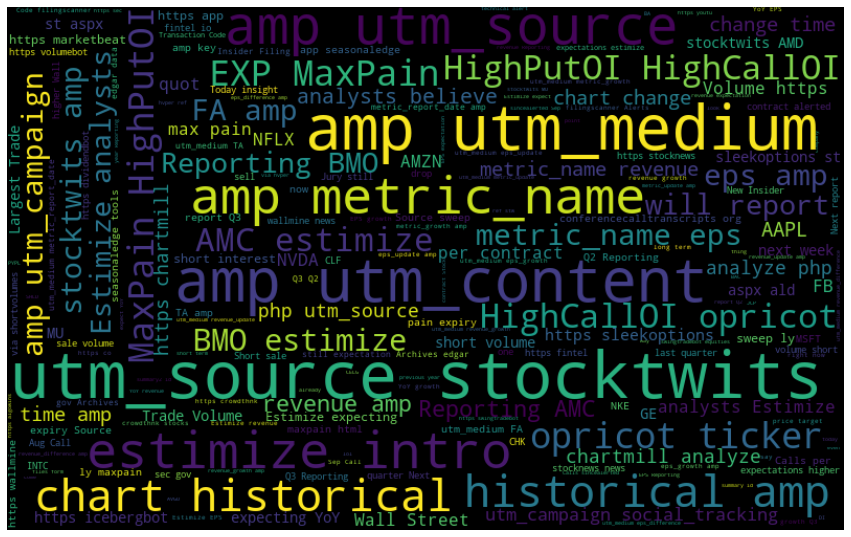

In [61]:
# Understanding all the words
all_words = ' '.join([text for text in tweetnn_df2['stocktwit_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Some observations :-
a. utm_medium, utm_source means there are a lot of urls present.- needs to be handled.
b. a lot of amp is present : have to go back and check this information.
c. a lot of https is also observed here.
d. stocktwits is also observed. - 

After reading the data its clear that these information is coming from urls present in the data and that needs to be handled.


In [68]:
#Removing https
tweetnn_df2['tweet'] = tweetnn_df2['stocktwit_tweet'].apply(lambda x: re.sub(r"http\S+", "",x))

In [72]:
tweetnn_df2.to_csv("tweet_nourl.csv")

In [63]:
stc_cont=tweetnn_df2['stocktwit_tweet'].str.count("stocktwits")

In [65]:
stc_cont.sum()

62399

In [70]:
twt_cnt=tweetnn_df2['tweet'].str.count("stocktwits")

In [71]:
twt_cnt.sum()

319

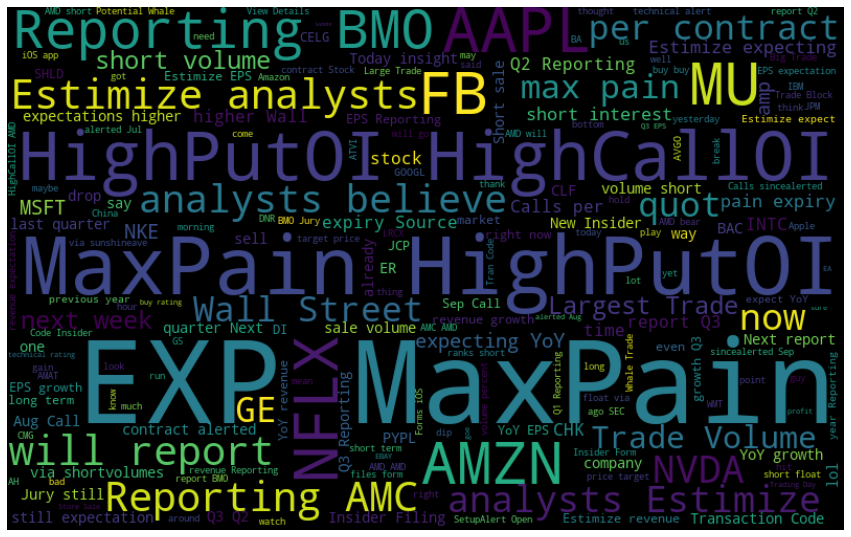

In [73]:
# Understanding all the words
all_words = ' '.join([text for text in tweetnn_df2['tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [74]:
twt_nourl=tweetnn_df2.copy()

In [75]:
#Replacing numbers, special characters and punctuations
tweetnn_df2['tweet'] = tweetnn_df2['tweet'].str.replace("[^a-zA-Z#]", " ")

In [79]:
# Split data into training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(tweetnn_df2['tweet'], 
                                                    tweetnn_df2['sentiment_score'], train_size=0.8,
                                                    random_state=1234)

In [80]:
y_train2.shape

(831304,)

In [81]:
#Tokenizing the sentences/tweets
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train2)

X_train2 = tokenizer.texts_to_sequences(X_train2)
X_test2 = tokenizer.texts_to_sequences(X_test2)

In [82]:
#Padding the tokenizers to make sure minimum limit of words is handled

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

maxlen = 100

X_train2 = pad_sequences(X_train2, padding='post', maxlen=maxlen)
X_test2 = pad_sequences(X_test2, padding='post', maxlen=maxlen)

#### Using Glove to build word relations

In [83]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/Users/vedprakashdwivedi/Desktop/Insofe/glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [84]:
embedding_matrix_nn = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_nn[index] = embedding_vector

In [85]:
# 'to_categorical' converts the class labels to one-hot vectors
from keras.utils import to_categorical
y_train2 = to_categorical(y_train2)
y_test2 = to_categorical(y_test2)

#### Model-2 

In [86]:
model_2 = Sequential()
embedding_layer2 = Embedding(vocab_size, 100, weights=[embedding_matrix_nn], input_length=maxlen , trainable=False)
model_2.add(embedding_layer2)
model_2.add(LSTM(128))

model_2.add(Dense(5, activation='softmax'))
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [87]:
history_model_2 = model_2.fit(X_train2, y_train2, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score_model_2 = model_2.evaluate(X_test2, y_test2, verbose=1)

Train on 665043 samples, validate on 166261 samples
Epoch 1/6
665043/665043 [==============================] - 2301s 3ms/step - loss: 1.4318 - acc: 0.4465 - val_loss: 1.4296 - val_acc: 0.4472
Epoch 2/6
665043/665043 [==============================] - 2746s 4ms/step - loss: 1.4306 - acc: 0.4466 - val_loss: 1.4289 - val_acc: 0.4472
Epoch 3/6
665043/665043 [==============================] - 3980s 6ms/step - loss: 1.4305 - acc: 0.4466 - val_loss: 1.4286 - val_acc: 0.4472
Epoch 4/6
665043/665043 [==============================] - 3073s 5ms/step - loss: 1.4304 - acc: 0.4466 - val_loss: 1.4289 - val_acc: 0.4472
Epoch 5/6
665043/665043 [==============================] - 3042s 5ms/step - loss: 1.4303 - acc: 0.4466 - val_loss: 1.4291 - val_acc: 0.4472
Epoch 6/6
207827/207827 [==============================] - 310s 1ms/step


# Part - B: Hedge fund data 

### #### Columns in Hedge Fund data file:
1. Id: Index or unique identifier for a record.

2. date: The date at which the factors are generated

3. ticker: The hedge fund details

4. SF1 - SF7: 7 anonymized Stock Factors that can be used to predict.

5. alpha: The alpha signal generated by using a high performing algorithmic trading strategy. (range: 1 - 4)


### Reading the file

In [58]:
import pandas as pd
tfac=pd.read_csv("train_factors-1573207730757.csv")

### Understanding and pre processing the data

In [5]:
tfac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27006 entries, 0 to 27005
Data columns (total 11 columns):
Id        27006 non-null int64
date      27006 non-null object
ticker    27006 non-null object
SF1       27006 non-null float64
SF2       27006 non-null float64
SF3       27006 non-null float64
SF4       27006 non-null float64
SF5       27006 non-null float64
SF6       27006 non-null float64
SF7       27006 non-null float64
alpha     27006 non-null int64
dtypes: float64(7), int64(2), object(2)
memory usage: 2.3+ MB


'date' column is in the form of object which needs to get converted to datetime object for any date related processing.

In [25]:
# Converting date column into datatime object
tfac['ticker_date']=pd.to_datetime(tfac['date'],format='%d/%m/%y')

In [26]:
tfac.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,ticker_date
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,2018-08-21
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,2018-10-11
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,2018-08-21
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,2018-07-10
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,2018-09-12


In [33]:
#Identifying the date range for the ticker information
print("Maximum ticker information date:",tfac.ticker_date.max())
print("Minimum ticker information date:",tfac.ticker_date.min())

Maximum ticker information date: 2018-10-31 00:00:00
Minimum ticker information date: 2018-07-01 00:00:00


In [11]:
#Finding details of ticker and its values
tfac.ticker.value_counts()

$BAC       90
$NVDA      89
$NFLX      88
$SHLD      88
$F         88
$GOOGL     88
$AMD       87
$FB        87
$ATVI      86
$CHK       86
$DIS       85
$MSFT      85
$MU        85
$AAPL      84
$IBM       83
$CELG      83
$BA        83
$JPM       82
$COST      82
$AAL       82
$GOOG      82
$LMT       82
$INTC      81
$CLF       81
$GE        80
$T         80
$CAT       80
$PYPL      79
$WYNN      79
$GME       79
           ..
$Ge         1
$TCEHY      1
$xrt        1
$PATK       1
$QDEL       1
$xec        1
$PFGC       1
$aes        1
$SSC        1
$sre        1
$OXLC       1
$xray       1
$Dal        1
$BGS        1
$SEND       1
$NETS       1
$kors       1
$HOTBTC     1
$SCX        1
$etr        1
$CLDR       1
$TOL        1
$SAEX       1
$FAANG      1
$EGAN       1
$BEL        1
$SZT        1
$duk        1
$Gm         1
$mtd        1
Name: ticker, Length: 1304, dtype: int64

In [65]:
check=pd.DataFrame(tfac.ticker.value_counts())

In [66]:
check.head(5)

,ticker
$BAC,90
$NVDA,89
$NFLX,88
$F,88
$GOOGL,88


In [67]:
len(check[check.ticker==1])

402

In [68]:
check[check.ticker==1].head(5)

,ticker
$HSC,1
$TEVA,1
$TNDM,1
$adi,1
$re,1


In [29]:
#Finding unique values in the ticker data
tfac.nunique()

Id             27006
date             123
ticker          1304
SF1            26703
SF2            26703
SF3            26703
SF4            26703
SF5            26703
SF6            26703
SF7            26703
alpha              4
ticker_date      123
dtype: int64

This clearly shows that there are only 123 dates that has been considered and which are unique, which means it comprises of data of close to <b>4 months</b>.

In [32]:
inspect_data(tfac)

,Data Type,Count of Blank Values,Count of Missing Values,% of Missing Values,No of Unique Data,Levels
Id,int64,0,0,0.0,27006,[1 2 3 ... 27004 27005 27006]
date,object,0,0,0.0,123,['21/08/18' '11/10/18' '10/07/18' '12/09/18' '...
ticker,object,0,0,0.0,1304,['$NTAP' '$WYNN' '$DRI' ... '$GEVO' '$QTM' '$a...
SF1,float64,0,0,0.0,26703,[-0.628651934 1.315785931 -1.141388142 ... 1.3...
SF2,float64,0,0,0.0,26703,[0.98889147 1.4387540019999998 -1.455015676999...
SF3,float64,0,0,0.0,26703,[-0.055714478 0.18732718199999998 0.332754543 ...
SF4,float64,0,0,0.0,26703,[0.774378771 0.608933159 0.674501682 ... -0.27...
SF5,float64,0,0,0.0,26703,[0.551088847 -1.153029724 0.11132613699999999 ...
SF6,float64,0,0,0.0,26703,[-1.329228593 1.85944112 -0.478596905 ... -1.5...
SF7,float64,0,0,0.0,26703,[-0.995539498 0.730995043 -1.4881567119999999 ...


#### Observation:-

<li>alpha is a categorical data which is having only 4 labels.
<li> Id column can be dropped as it is just an index value.
<li> Total 1304 Ticker/Hedge Fund's information is available.
<li> There are <b> no missing values </b> in entire dataset.

In [36]:
# Dropping ID column as we already have index values
cols=['Id']
tfac.drop(columns=cols,axis=1,inplace=True)

In [37]:
#Understanding the distribution of data
tfac.describe()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
count,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000
mean,0.005429,-0.001005,-0.024421,-0.042420,0.041465,0.002597,0.036744,2.379582
std,0.941853,0.996130,0.539555,1.111309,0.976028,0.998839,1.204473,1.008681
min,-4.114670,-4.578587,-2.609150,-6.329798,-5.480268,-4.338751,-5.347869,1.000000
25%,-0.596792,-0.666310,-0.300187,-0.767247,-0.518641,-0.668027,-0.688198,2.000000
50%,0.012104,-0.013257,-0.040786,-0.058629,0.072127,0.007417,0.081374,2.000000
75%,0.611574,0.669094,0.241424,0.677433,0.616538,0.674592,0.807556,3.000000
max,4.415048,3.822270,3.452486,4.907407,4.779911,4.075428,5.182912,4.000000


#### Key observations :-
<li> SF1-SF7 has 25%ile-75%ile value between -0.5 and 0.6/0.8 and max is 4 or higher, this surely means that there are outliers towards the right side or above 75%ile value

In [38]:
# Converting alpha to object as it has discrete values
tfac['alpha']=tfac['alpha'].astype('object')

In [39]:
tfac.dtypes

date                   object
ticker                 object
SF1                   float64
SF2                   float64
SF3                   float64
SF4                   float64
SF5                   float64
SF6                   float64
SF7                   float64
alpha                  object
ticker_date    datetime64[ns]
dtype: object

In [40]:
#Understanding distribution of alpha values
tfac.alpha.value_counts()

2    10912
3     5536
1     5467
4     5091
Name: alpha, dtype: int64

#### There is a class Imbalance present in the dataset as observed above.
##### Alpha value=2 is 2 times of any other alpha types

### Finding out the months for which the hedge fund data has been provided

In [41]:
# Getting information of months
tfac['ticker_month']=tfac['ticker_date'].apply(lambda x:x.month)

In [42]:
tfac.head()

,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,ticker_date,ticker_month
0,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,2018-08-21,8
1,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,2018-10-11,10
2,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,2018-08-21,8
3,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,2018-07-10,7
4,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,2018-09-12,9


In [43]:
#Understanding month wise split of data
tfac.ticker_month.value_counts()

8     7099
10    6888
7     6800
9     6219
Name: ticker_month, dtype: int64

Clearly for every month we have equal amount of data present

In [61]:
#Converting month to object type as it has only 4 values
tfac['ticker_month']=tfac['ticker_month'].astype('object')

In [62]:
tfac.dtypes

date                    object
ticker                  object
SF1                    float64
SF2                    float64
SF3                    float64
SF4                    float64
SF5                    float64
SF6                    float64
SF7                    float64
alpha                   object
ticker_date     datetime64[ns]
ticker_month            object
dtype: object

## Story Generation and visualization

### 1. Understanding variation of different numeric attributes for various alpha values

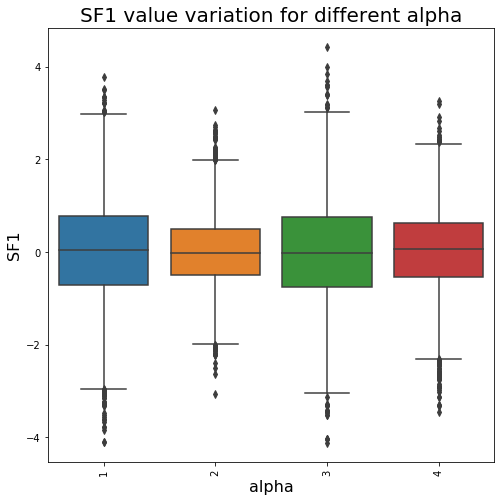

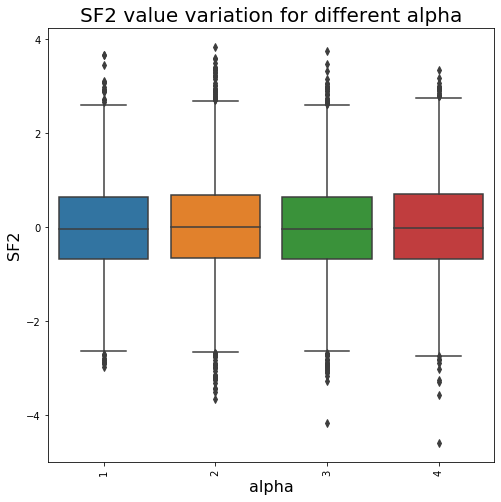

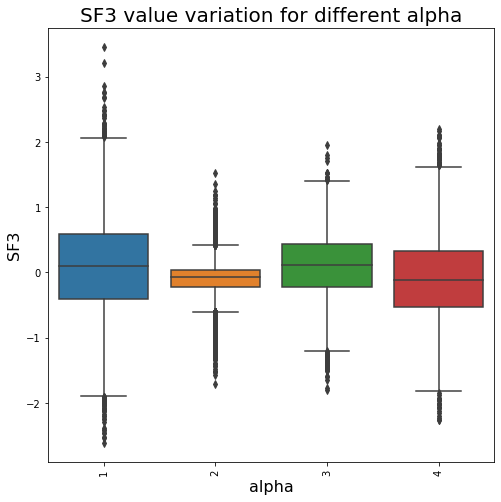

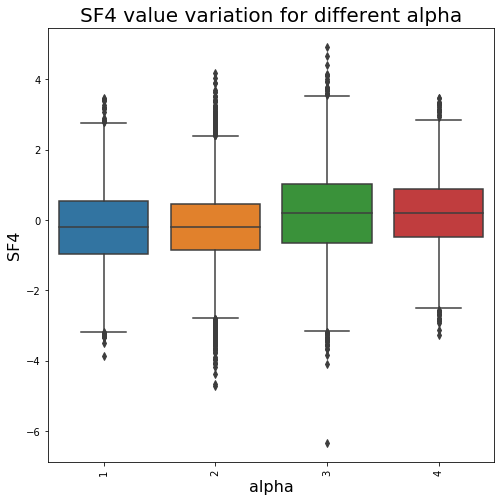

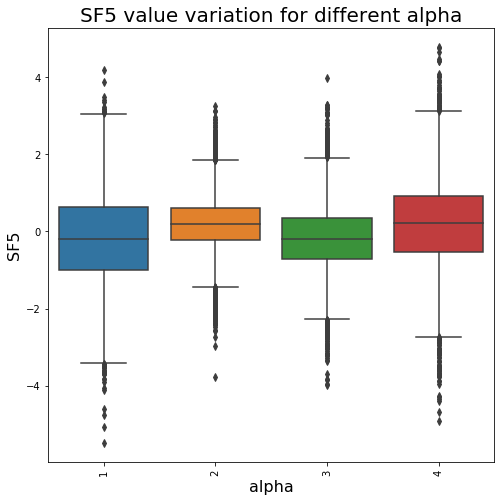

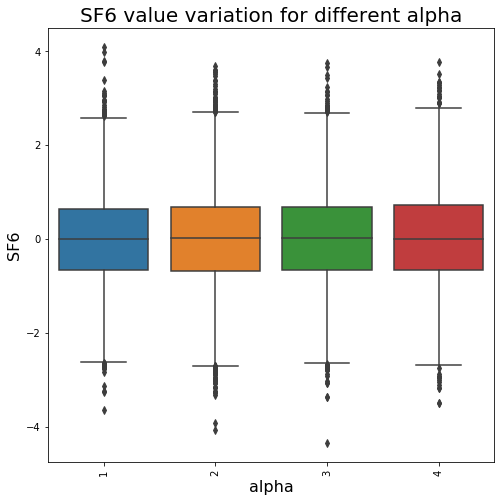

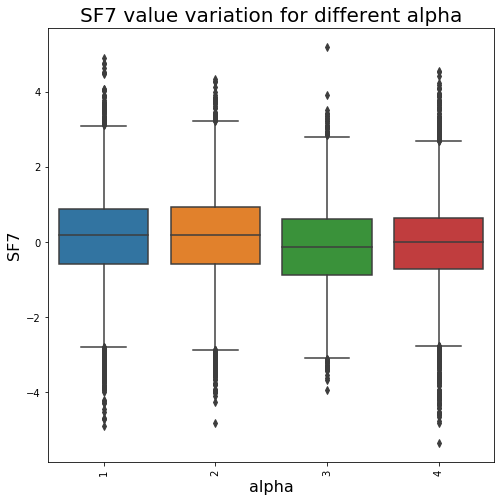

In [60]:
cols=['SF1','SF2','SF3','SF4','SF5','SF6','SF7']
    #fig,ax=plt.subplots(figsize=(10,10))
for col in cols:
    fig,ax=plt.subplots(figsize=(8,8))
    sns.boxplot(y=col,x='alpha',data=tfac)
    plt.xticks(fontsize=10,rotation=90)
    plt.yticks(fontsize=10)
    plt.xlabel('alpha',fontsize=16)
    plt.ylabel(col,fontsize=16)
    plt.title(col +' value variation for different alpha',fontsize=20)
    plt.show()

### Observations from above plots:-
<li>SF1 has more variation of data for alpha value of 1 and 3 
<li>SF2 has equal distribution across all alpha values.
<li>SF3 has less data variaton for alpha =2
<li>SF4 has more data variation for alpha=3
<li>SF5 has less data variation for alpha=2
<li>SF6 and SF7 have almost equal data spread across all alpha values  

### Plotting heatmap to understand correlations

In [76]:
# Corelation
cor = tfac.corr()
cor

,SF1,SF2,SF3,SF4,SF5,SF6,SF7
SF1,1.000000,0.003338,-0.385151,-0.156248,-0.202912,0.003960,0.814309
SF2,0.003338,1.000000,-0.007591,-0.015122,0.005073,-0.016984,0.011543
SF3,-0.385151,-0.007591,1.000000,0.262503,-0.823332,-0.013038,-0.529095
SF4,-0.156248,-0.015122,0.262503,1.000000,-0.117114,-0.006745,-0.690205
SF5,-0.202912,0.005073,-0.823332,-0.117114,1.000000,0.011143,0.026781
SF6,0.003960,-0.016984,-0.013038,-0.006745,0.011143,1.000000,0.008009
SF7,0.814309,0.011543,-0.529095,-0.690205,0.026781,0.008009,1.000000


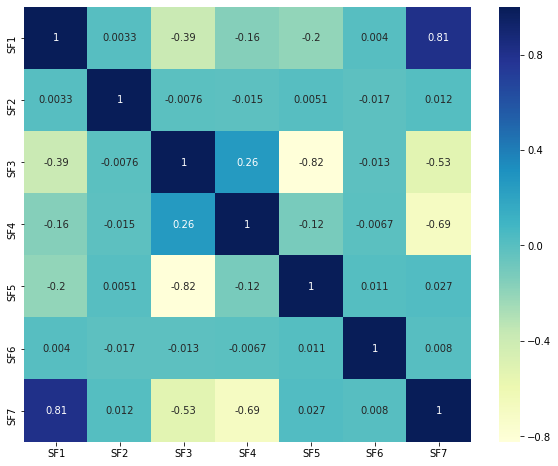

In [81]:
#plotting a correlation heat map
plt.figure(figsize=(10,8))
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

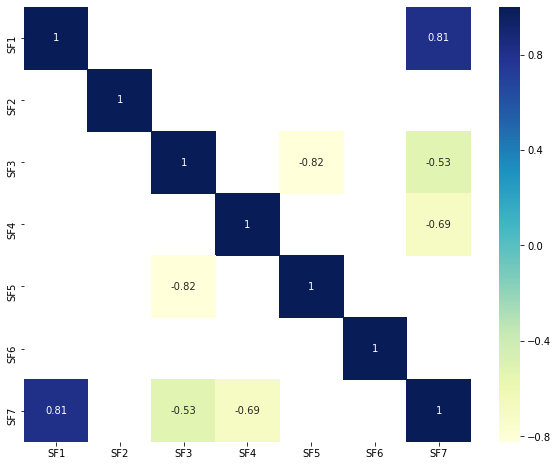

In [80]:
#clearing up the correlation plot for better understanding of heat map
plt.figure(figsize=(10,8))
sns.heatmap(cor[(cor>=0.5)|(cor<=-0.5)], cmap="YlGnBu", annot=True)
plt.show()

### Observation:-
<li> SF7 and SF1 are highly and positively correlated.
<li> SF3 and SF5 are highly negatively correlated.
<li> SF7 and SF3 are negatively correlated to a medium value.
<li> SF7 and SF4 are highly negatively correlated.    

Text(0, 0.5, 'SF1')

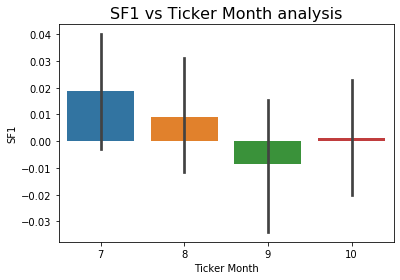

In [86]:
sns.barplot(x = 'ticker_month', y='SF1', data=tfac)
plt.title("SF1 vs Ticker Month analysis",fontsize=16)
plt.xlabel("Ticker Month",fontsize=10)
plt.ylabel("SF1",fontsize=10)

For the 9th month, the median value of SF1 is very low. Also for 10th month there is very less SF1 variation.

Text(0, 0.5, 'SF2')

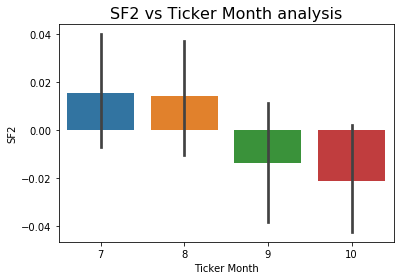

In [87]:
sns.barplot(x = 'ticker_month', y='SF2', data=tfac)
plt.title("SF2 vs Ticker Month analysis",fontsize=16)
plt.xlabel("Ticker Month",fontsize=10)
plt.ylabel("SF2",fontsize=10)

Surely there is a lot of variation in the 10th month, while the median value being the highest across 7th and 8th month.

Text(0, 0.5, 'SF3')

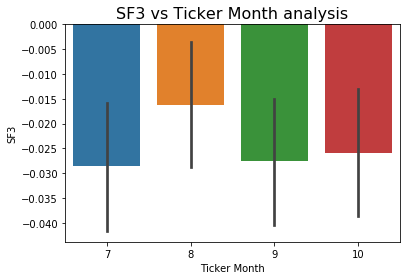

In [89]:
sns.barplot(x = 'ticker_month', y='SF3', data=tfac)
plt.title("SF3 vs Ticker Month analysis",fontsize=16)
plt.xlabel("Ticker Month",fontsize=10)
plt.ylabel("SF3",fontsize=10)

Very less data variation for 8th month vs other months for SF3

Text(0, 0.5, 'SF4')

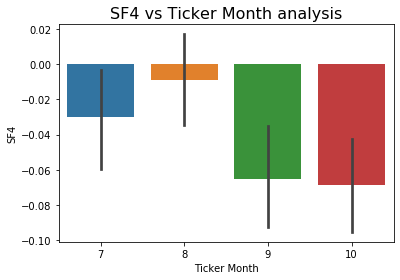

In [90]:
sns.barplot(x = 'ticker_month', y='SF4', data=tfac)
plt.title("SF4 vs Ticker Month analysis",fontsize=16)
plt.xlabel("Ticker Month",fontsize=10)
plt.ylabel("SF4",fontsize=10)

For 8th month the variation in SF4 is less compared to other months.

Text(0, 0.5, 'SF5')

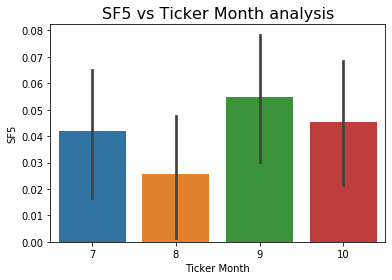

In [91]:
sns.barplot(x = 'ticker_month', y='SF5', data=tfac)
plt.title("SF5 vs Ticker Month analysis",fontsize=16)
plt.xlabel("Ticker Month",fontsize=10)
plt.ylabel("SF5",fontsize=10)

For 8th month the variation in SF5 is less compared to other months.

Text(0, 0.5, 'SF6')

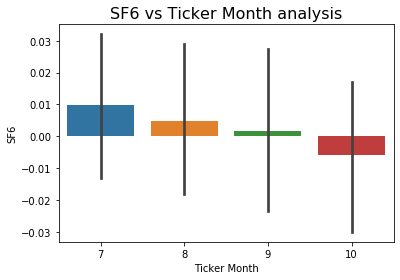

In [92]:
sns.barplot(x = 'ticker_month', y='SF6', data=tfac)
plt.title("SF6 vs Ticker Month analysis",fontsize=16)
plt.xlabel("Ticker Month",fontsize=10)
plt.ylabel("SF6",fontsize=10)

SF6 shows very less data variation for 9th month.

Text(0, 0.5, 'SF7')

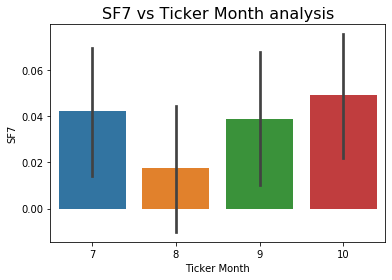

In [93]:
sns.barplot(x = 'ticker_month', y='SF7', data=tfac)
plt.title("SF7 vs Ticker Month analysis",fontsize=16)
plt.xlabel("Ticker Month",fontsize=10)
plt.ylabel("SF7",fontsize=10)

For 8th month the variation in SF7 is less compared to other months.